In [1]:
!unzip feedback-prize-english-language-learning.zip

Archive:  feedback-prize-english-language-learning.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [21]:
!pip install numpy nltk --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 37.9 MB/s eta 0:00:00
  Attempting uninstall: nltk
    Found existing installation: nltk 3.7
    Uninstalling nltk-3.7:
      Successfully uninstalled nltk-3.7


In [59]:
import pandas as pd
from pandas.api.types import CategoricalDtype
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
from nltk import word_tokenize
import nltk
from nltk.tokenize import sent_tokenize
from gensim.utils import simple_preprocess
nltk.download('punkt')
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import accuracy_score, mean_squared_error

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
data = pd.read_csv("train.csv")
data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5


In [3]:
data.describe()

,cohesion,syntax,vocabulary,phraseology,grammar,conventions
count,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000,3911.000000
mean,3.127077,3.028254,3.235745,3.116850,3.032856,3.081053
std,0.662542,0.644399,0.583148,0.655997,0.699841,0.671450
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,2.500000,2.500000,3.000000,2.500000,2.500000,2.500000
50%,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
75%,3.500000,3.500000,3.500000,3.500000,3.500000,3.500000
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


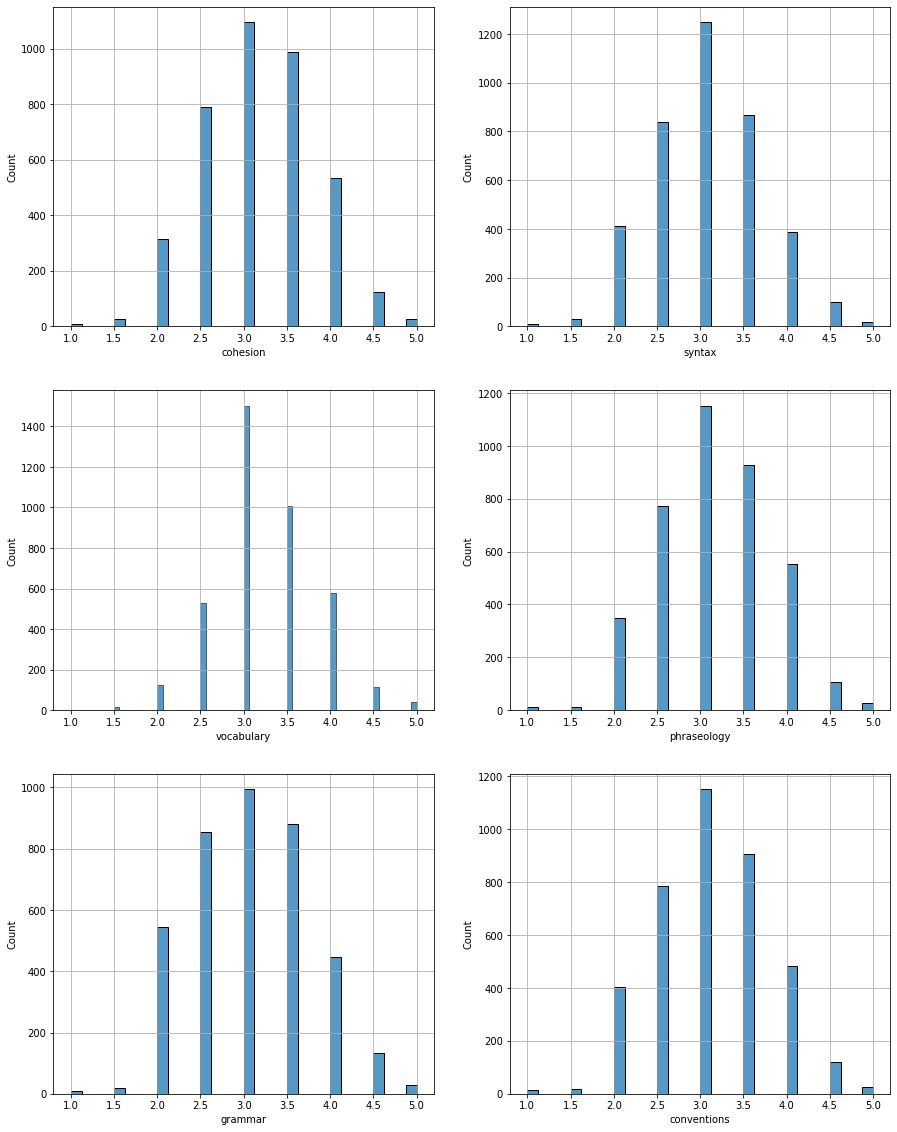

In [4]:
train_scores=data.drop(columns=["full_text","text_id"])
n=1
plt.figure(figsize=(15,20))
for i in train_scores.columns:
    #Use of subplot for better presentation
    plt.subplot(3,2,n)
    plt.grid()
    sns.histplot(data=train_scores,x=i)
    n +=1

Text(0.5, 1.0, 'Distribution of total text Length')

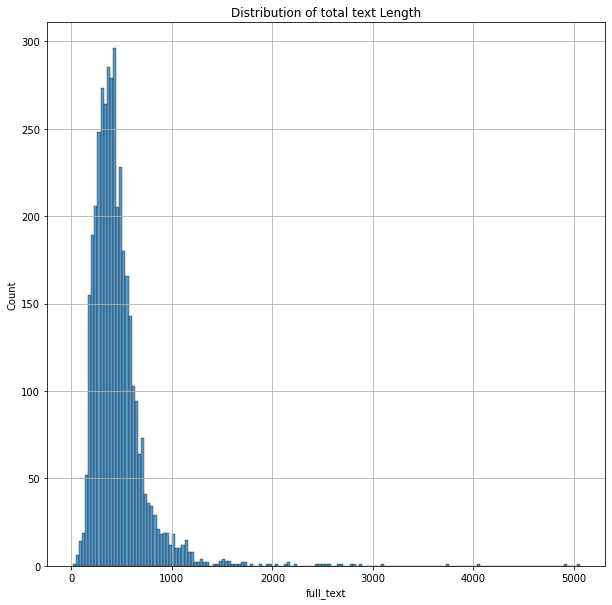

In [5]:
total_words=data.full_text.apply(lambda x: len(x.split(" ")))
plt.figure(figsize=(10,10))
sns.histplot(total_words)
plt.grid()
plt.title("Distribution of total text Length")

In [6]:
total_words.mean()

461.13040143185884

In [7]:
data['full_text_low'] = data.full_text.apply(lambda x: x.lower())
data.head()

,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions,full_text_low
0,0016926B079C,I think that students would benefit from learn...,3.5,3.5,3.0,3.0,4.0,3.0,i think that students would benefit from learn...
1,0022683E9EA5,When a problem is a change you have to let it ...,2.5,2.5,3.0,2.0,2.0,2.5,when a problem is a change you have to let it ...
2,00299B378633,"Dear, Principal\n\nIf u change the school poli...",3.0,3.5,3.0,3.0,3.0,2.5,"dear, principal\n\nif u change the school poli..."
3,003885A45F42,The best time in life is when you become yours...,4.5,4.5,4.5,4.5,4.0,5.0,the best time in life is when you become yours...
4,0049B1DF5CCC,Small act of kindness can impact in other peop...,2.5,3.0,3.0,3.0,2.5,2.5,small act of kindness can impact in other peop...


In [26]:
token_lists_lower = [word_tokenize(each) for each in data.full_text_low]
tokens_lower = [item for sublist in token_lists_lower for item in sublist]
print("Number of unique tokens with lowercase: ", len(set(tokens_lower)))

Number of unique tokens with lowercase:  22473


In [27]:
nltk.download('stopwords')
stopwords_corpus = nltk.corpus.stopwords
eng_stop_words = stopwords_corpus.words('english')
print(len(eng_stop_words))

179


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [28]:
data["Length"]=data.full_text.apply(lambda x: len(x.split(" ")))
# Total number of stopwords
data["Stopwords"]=data.full_text_low.apply(lambda x: len([w for w in x.split(" ") if w in eng_stop_words]))

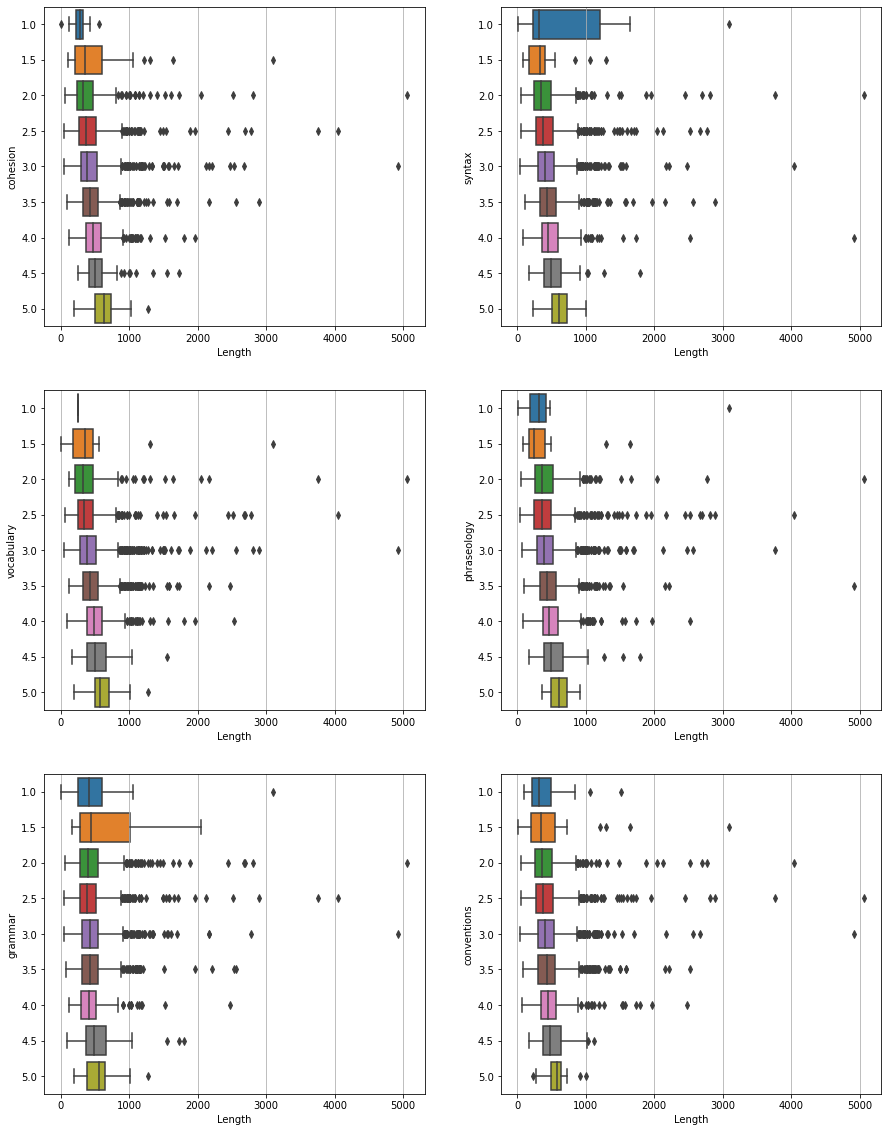

In [15]:
analysis_columns=["cohesion","syntax","vocabulary","phraseology","grammar","conventions"]
type_at=CategoricalDtype(ordered=True)
for i in analysis_columns:
    data[i]=data[i].astype(type_at)
plt.figure(figsize=(15,20))
n=1
for i in analysis_columns:
    plt.subplot(3,2,n)
    plt.grid()
    sns.boxplot(data=data,x="Length",y=i)
    n +=1

In [18]:
!pip install gensim --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.1/24.1 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.1/67.1 KB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for fst-pso: filename=fst_pso-1.8.1-py3-none-any.whl size=20443 sha256=f10e16cc823bf03cad29758be33407d59aa638d7fdf8cfd67a3407fe7ce68207
  Stored in directory: /root/.cache/pip/wheels/6a/65/c4/d27eeee9ba3fc150a0dae150519591103b9e0dbffde3ae77dc
  Created wheel for miniful: filename=miniful-0.0.6-py3-none-any.whl size=3530 sha256=8a303edcb90e31ecd0164590ee10efde4a5d491047ad5aaf1ddc0c19ac23ddb2
  Stored in directory: /root/.cache/pip/wheels/ba/d9/a0/ddd93af16d5855dd9bad417623e70948fdac119d1d34fb17c8
Successfully built fst-pso miniful
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0

In [29]:
data['full_text'] = data['full_text'].apply(lambda x: x.lower())
story = []
for doc in data['full_text']:
    raw_sent = sent_tokenize(doc)
    for sent in raw_sent:
        story.append(simple_preprocess(sent))

model = gensim.models.Word2Vec(
    vector_size=200,
    window=5,
    min_count=2
)

model.build_vocab(story)

model.train(story, total_examples=model.corpus_count, epochs=5)


(5560809, 8109125)

In [53]:
def document_vector(doc):
    # remove out-of-vocabulary words
    doc = [word for word in doc.split() if word in model.wv.index_to_key]
    return np.mean(model.wv[doc], axis=0)


In [54]:
from tqdm import tqdm
X = []
for doc in tqdm(data['full_text'].values):
    X.append(document_vector(doc))

100%|██████████| 3911/3911 [02:14<00:00, 29.15it/s]


In [55]:
test = pd.read_csv("test.csv")

In [56]:
from tqdm import tqdm
X1 = []
for doc in tqdm(test['full_text'].values):
    X1.append(document_vector(doc))

100%|██████████| 3/3 [00:00<00:00, 27.01it/s]


In [57]:
X = np.array(X)
X1 = np.array(X1)

In [62]:
columns = data.columns.to_list()[2::]
metric1 = []

for col in tqdm(columns):
    
    y = ((data[col]*2)-2).values
    y = y.astype('int64')
    
    
    
    X_resampled, y_resampled = RandomOverSampler().fit_resample(X, y)
    
    #X_train,X_test,y_train,y_test = train_test_split(X_resampled, y_resampled,test_size=0.2,random_state=1, stratify=y_resampled)
    
    dtree_model = RandomForestRegressor(random_state=1)

    dtree_model.fit(X_resampled, y_resampled)
    y_pred = dtree_model.predict(X_resampled)
    
    metric1.append(np.sqrt(mean_squared_error(y_resampled, y_pred)))
    
    test[col] = (np.clip((dtree_model.predict(X1)+2)/2, 1, 5)).astype('float64')
    #print(grid.best_params_)
                  
print('metric:', '\t', np.mean(metric1))    
test

100%|██████████| 6/6 [10:01<00:00, 100.32s/it]

metric: 	 0.17929730990577622


,text_id,full_text,cohesion,syntax,vocabulary,phraseology,grammar,conventions
0,0000C359D63E,when a person has no experience on a job their...,3.14,2.820,3.285,3.135,2.645,2.715
1,000BAD50D026,Do you think students would benefit from being...,3.16,2.920,2.890,2.950,2.530,3.020
2,00367BB2546B,"Thomas Jefferson once states that ""it is wonde...",3.29,3.235,3.415,3.490,3.340,3.430
